In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import oscarplus as op
import plot_helpers as ph
import subplots as splot

In [2]:
# select files
dates = ["20220517", "20220522"]
tracks_17 = ["1", "2"]
tracks_22 = ["1", "1b", "2", "2b"]
gmf = "mouche12kp20_rsv20"
resolution = "200x200m"

# input for plotting
bin_width = 2.5

In [3]:
# functions
def import_prepare_OSCAR(date, track, datasets, datasets_coarsened, downscale_factor):
    # Load the dataset for the current track
    L2a_MF, _ = op.tools.readers.read_OSCAR(date, track, gmf, "L2a MF", resolution)

    # Add a new coordinate for the track
    L2a_MF = L2a_MF.assign_coords(datetrack=f"{date}_{track}")

    # Store the dataset in the list
    datasets.append(L2a_MF)

    # Coarsen the dataset
    L2a_MF_coarsened = op.processing.filtering.downscale(L2a_MF, downscale_factor)

    # Re-calculate secondary products
    op.processing.secondary_products.calculate_secondary_products(L2a_MF_coarsened)
    datasets_coarsened.append(L2a_MF_coarsened)
    return datasets, datasets_coarsened

In [4]:
# Read the datasets
datasets = []
datasets_coarsened = []
downscale_factor = 5

# Loop through tracks and read datasets
date = dates[0]
for track in tracks_17:
    datasets, datasets_coarsened = import_prepare_OSCAR(
        date, track, datasets, datasets_coarsened, downscale_factor
    )
date = dates[1]
for track in tracks_22:
    datasets, datasets_coarsened = import_prepare_OSCAR(
        date, track, datasets, datasets_coarsened, downscale_factor
    )

In [5]:
# Merge the datasets
merged_dataset = xr.concat(datasets, dim="datetrack")
merged_dataset_coarsened = xr.concat(datasets_coarsened, dim="datetrack")

Min OSCAR Current Divergence 200m: -39.49297807828041
Max OSCAR Current Divergence 200m: 38.02609205802761
Min OSCAR Current Divergence 1km: -7.049565245623943
Max OSCAR Current Divergence 1km: 9.68829566632676


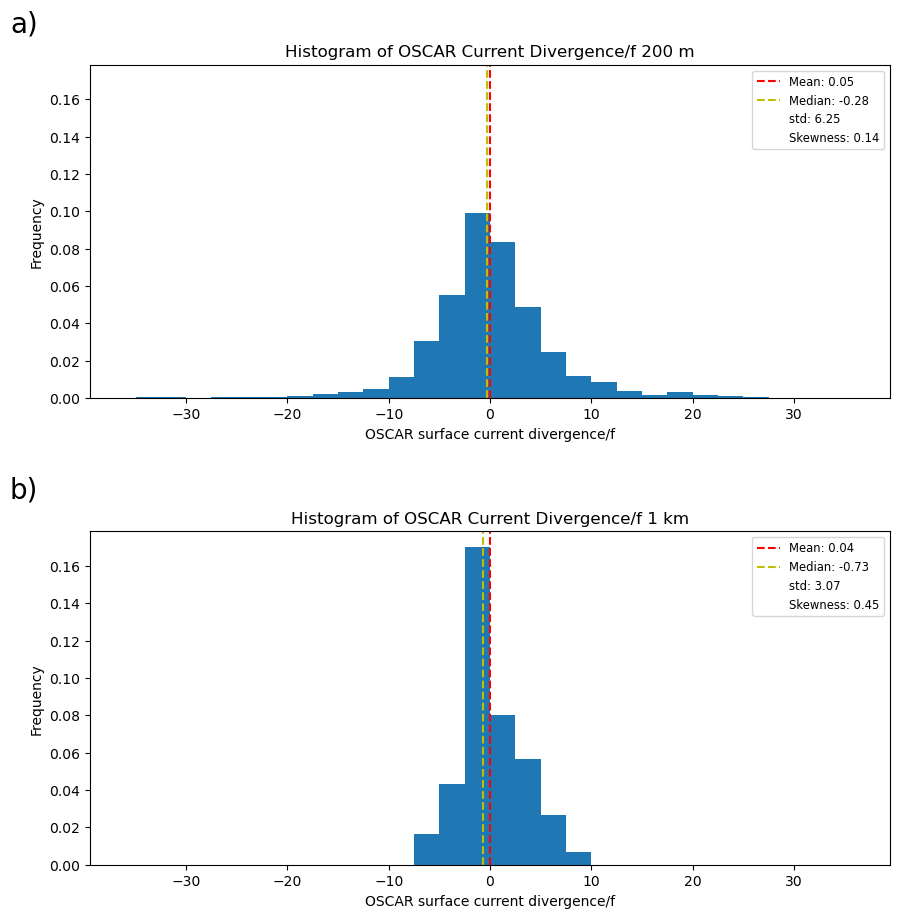

In [6]:
# Figures
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# # Scatter plot for 200 m resolution
# for DS in datasets:
#     axes[0, 0].scatter(DS["CurrentVelocity"], DS["CurrentDivergence"], alpha=0.5, s=15)
#     axes[0, 0].set_title("OSCAR 200 m")
#     axes[0, 0].set_xlabel("Current Velocity [m/s]")
#     axes[0, 0].set_ylabel("Divergence/f")

# # Scatter plot for 1 km resolution
# for DS in datasets_coarsened:
#     axes[0, 1].scatter(DS["CurrentVelocity"], DS["CurrentDivergence"], alpha=0.5, s=15)
#     axes[0, 1].set_title("OSCAR 1000 m")
#     axes[0, 1].set_xlabel("Current Velocity [m/s]")
#     axes[0, 1].set_ylabel("Divergence/f")
#     axes[0, 1].set_xlim(axes[0, 0].get_xlim())
#     axes[0, 1].set_ylim(axes[0, 0].get_ylim())

# # Add legends
# axes[0, 0].legend([DS.datetrack.values for DS in datasets], loc="lower right")
# axes[0, 1].legend([DS.datetrack.values for DS in datasets_coarsened], loc="lower right")

# For the histograms, we want to have the same x-axis limits for both plots
xlim = max(
    abs(np.nanmax(merged_dataset["CurrentDivergence"].values)),
    abs(np.nanmax(merged_dataset_coarsened["CurrentDivergence"].values)),
    abs(np.nanmin(merged_dataset["CurrentDivergence"].values)),
    abs(np.nanmin(merged_dataset_coarsened["CurrentDivergence"].values)),
)

# Histograms
splot.histogram_with_stats(
    merged_dataset["CurrentDivergence"],
    "OSCAR Current Divergence/f 200 m",
    axes[0],
    xlim=xlim,
    bin_width=bin_width,
)
splot.histogram_with_stats(
    merged_dataset_coarsened["CurrentDivergence"],
    "OSCAR Current Divergence/f 1 km",
    axes[1],
    xlim=xlim,
    bin_width=bin_width,
)

# Set the same y-axis limits for both histograms
ylim = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, ylim)
axes[1].set_ylim(0, ylim)

# Print the min and max values of the histograms
print(
    "Min OSCAR Current Divergence 200m:",
    merged_dataset["CurrentDivergence"].min().values,
)
print(
    "Max OSCAR Current Divergence 200m:",
    merged_dataset["CurrentDivergence"].max().values,
)
print(
    "Min OSCAR Current Divergence 1km:",
    merged_dataset_coarsened["CurrentDivergence"].min().values,
)
print(
    "Max OSCAR Current Divergence 1km:",
    merged_dataset_coarsened["CurrentDivergence"].max().values,
)

# Add letters to the subplots and adjust the layout
ph.add_letters(axes)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.4)